In [1]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data
    
    #remove old setup files
    !rm setup.sh

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   do_setup()  

In [2]:
# !chmod 600 /root/.kaggle/kaggle.json

In [3]:
import pandas as pd
df =pd.read_csv('./data/train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [4]:
try: from path import Path
except ModuleNotFoundError:
    !pip install path
try: import timm
except ModuleNotFoundError:
    !pip install timm

In [5]:
from fastai.vision.all import *
set_seed(42)

path =Path('./data/')

In [6]:
path.ls()

(#5) [Path('data/train_images'),Path('data/train.csv'),Path('data/sample_submission.csv'),Path('data/paddy-disease-classification.zip'),Path('data/test_images')]

In [7]:
files=get_image_files(path/'train_images')
files

(#10407) [Path('data/train_images/bacterial_leaf_streak/100081.jpg'),Path('data/train_images/bacterial_leaf_streak/104135.jpg'),Path('data/train_images/bacterial_leaf_streak/108249.jpg'),Path('data/train_images/bacterial_leaf_streak/100235.jpg'),Path('data/train_images/bacterial_leaf_streak/105265.jpg'),Path('data/train_images/bacterial_leaf_streak/109925.jpg'),Path('data/train_images/bacterial_leaf_streak/106054.jpg'),Path('data/train_images/bacterial_leaf_streak/103307.jpg'),Path('data/train_images/bacterial_leaf_streak/106974.jpg'),Path('data/train_images/bacterial_leaf_streak/101151.jpg')...]

(480, 640)


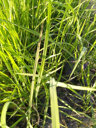

In [8]:
img=PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes=parallel(f,files,n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [10]:
trnpath=path/'train_images'

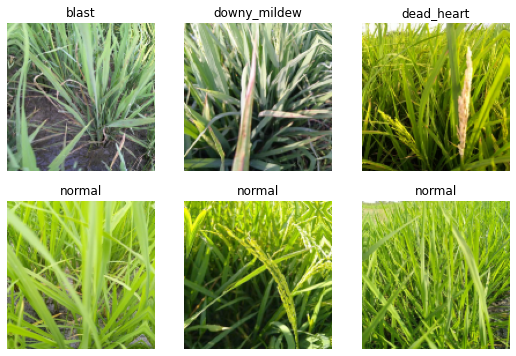

In [43]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480, method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

In [44]:
learn=vision_learner(dls,'resnet26d', metrics=error_rate,path='.')
model1=learn.model

In [13]:
# learn.lr_find(suggest_funcs=(valley,slide))

In [14]:
# learn.fine_tune(3,0.01)

### Try multihead

In [15]:
# #get the model thats part of learner
# m=learn.model
# # m

# #gets the head of the model
# h=m[1]
# h

# #subtract the last layer
# ll=h[-1]
# ll

# llp=list(ll.parameters())[0]

# #get rid of last linear layer in model
# del(h[-1])
# # m

# # learn.model

## Multihead

In [16]:
#creae a dict that maps from image_id to variety
img_id=df.image_id
variety=df.variety

itov=dict(zip(img_id,variety))

def getvariety(p): return itov[p.name]
    

In [61]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(192,method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [60]:
dblock=DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),   #ImageBlock works if passed a path to image, CategoryBlock works if passed a string to categorify to an int
                 n_inp=1,   #imageblock
                 get_items=get_image_files,
                 get_y=[parent_label,getvariety],  #2 cat blocks ricetype and disease variety type
                 splitter=RandomSplitter(0.2, seed=42),
                 item_tfms=Resize(192,method='squish'),
                 batch_tfms=aug_transforms(size=128, min_scale=0.75))

In [19]:
train_pth=path/'train_images'
train_pth

Path('data/train_images')

In [20]:
ds=dblock.datasets(train_pth)

In [21]:
fn=get_image_files(train_pth)[0]
print(fn)

# PILImage.create(fn)
print(parent_label(fn))
print(getvariety(fn))

data/train_images/bacterial_leaf_streak/100081.jpg
bacterial_leaf_streak
Onthanel


In [22]:
img,y1,y2=ds.train[1]

In [23]:
y1

TensorCategory(5)

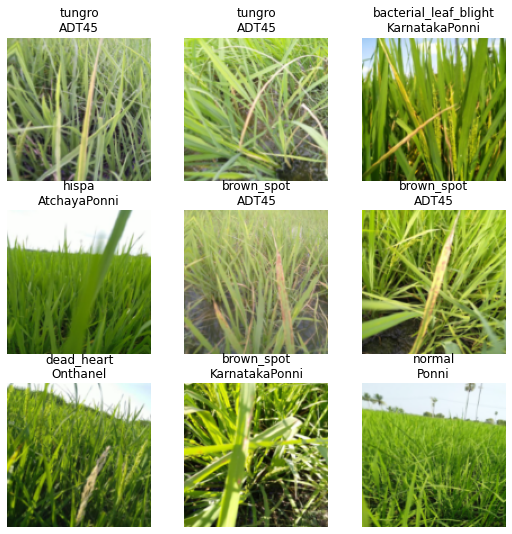

In [62]:
dls=dblock.dataloaders(train_pth)
dls.show_batch()

In [ ]:
#gets all the image files in a folder
# len(get_image_files('./data'))

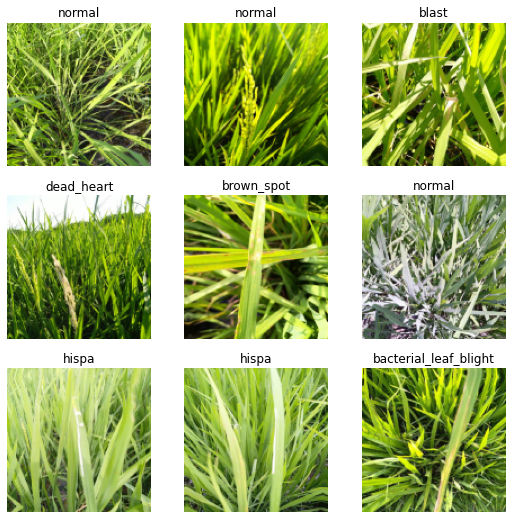

In [52]:
learn.dls.show_batch()

In [25]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,m):
        #lets strip the last layer out of the head
        del m[1][-1]
        super(DiseaseAndTypeClassifier,self).__init__()
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)  #disease
        self.m=m
        
    def forward(self,x):
        x=self.m(x)
        x1=self.l1(x)  #rice type
        x2=self.l2(x)  #disease
        return x1,x2
      

In [ ]:
# learn=vision_learner(dls,'resnet26d',  metrics=dtc_error)
dtc=DiseaseAndTypeClassifier(model1)

In [26]:
# Learner??

In [27]:
learn.loss_func
c_loss=learn.loss_func

In [56]:
def dtc_loss(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return c_loss(rice_preds,y_label)+c_loss(variety_preds,y_variety)

def dtc_error(preds,y_label,y_variety):
    rice_preds, variety_preds=preds
    return error_rate(rice_preds,y_label)+error_rate(variety_preds,y_variety)

In [63]:
learn.dls=dls
learn.model=dtc
learn.loss_func=dtc_loss
learn.metrics=[dtc_error]

In [54]:
preds=learn.get_preds(dl=learn.dls.valid)

SuggestedLRs(valley=0.004365158267319202)

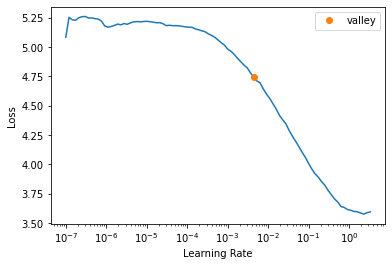

In [58]:
learn.lr_find()

In [64]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,dtc_error,time
0,1.217758,1.125744,0.366170,00:23


epoch,train_loss,valid_loss,dtc_error,time
0,0.872258,0.682364,0.209995,00:28
1,0.643730,0.531604,0.154253,00:28
2,0.495419,0.485573,0.146084,00:28


In [ ]:
#size of validation set?
len(learn.dls.valid.get_idxs())

In [ ]:
rice_preds, disease_preds=preds

In [ ]:
#copy and deepcopy is causing problems below
# from copy import copy,deepcopy
# arch='resnet26d'
# dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480),batch_tfms=aug_transforms(size=224, min_scale=0.75))
# learn3=vision_learner(dls,arch,metrics=error_rate)
# learn2=deepcopy(learn3)

### Old notebook

In [ ]:
llp.shape

In [ ]:
path

In [ ]:
ss=pd.read_csv(path/'sample_submission.csv')

In [ ]:
ss

In [ ]:
tst_files=get_image_files(path/'test_images').sorted()

tst_dl=dls.test_dl(tst_files)

In [ ]:
probs, bb, idxs=learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

In [ ]:
dls.vocab

In [ ]:
d=dict(enumerate(dls.vocab))

In [ ]:
idxs_np=idxs.clone()

In [ ]:
idxs

In [ ]:
vals=pd.Series(data=idxs, name="idxs").map(d)
vals

In [ ]:
ss.label=vals

In [ ]:
ss

In [ ]:
ss.to_csv('subm.csv',index=False)

In [ ]:
!pwd

In [ ]:
from kaggle import api
comp = 'paddy-disease-classification'
api.competition_submit_cli('subm.csv', 'init', comp)